In [15]:
# Implementing an Echo State Network in python
# Testing with small data set
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import pystan
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([1, 1, 1, 0])

In [24]:
class BayesianEchoStateNetwork:

  """
  Bayesian Echo state networks

  Fit the weights of a linear output model, using an normal prior. The weights of
  the regression model are assumed to be in Gaussian distributions.
  The estimation is done by a sampling procedure using pystan (MCMC).


  Parameters
  ----------
  n_chains : int , default = 4
    Number of chains for sampling posterior 

  iter : int, default = 4000
    Number of iterations for the sampling method

  priors: 'normal', 'gamma', or 'beta', default = 'normal'
    The prior for the bayesian neural networks

  
  normalize : bool, default=False
    Whether to normalize inputs to by subtracting the mean and 
    dividing by the l2-norm. 

  n_reservoir : int, deafult = 100
    The number of cells in the reservoir. 

  sparsity : float, default = 0.01
    The percentage of zero weighted connections in the reservoir. 
  
  
  References
  ----------
    Wang, L., Su, Z., Qiao, J. et al. Design of sparse Bayesian echo state network for time series prediction. 
    Neural Comput & Applic 33, 7089–7102 (2021). 
    https://doi.org/10.1007/s00521-020-05477-3


  """


  def __init__(self,n_chains=4, 
                iter=1000, 
                priors = 'normal', 
                normalize=False, 
                n_reservoir=100, 
                sparsity = 0.01,
                spectral_radius = 1):
    self.n_reservoir = n_reservoir
    self.n_chains = n_chains
    self.iter = iter
    self.priors = priors
    self.normalize = normalize
    self.n_reservoir = n_reservoir
    self.sparsity = sparsity
    self.spectral_radius = spectral_radius
    self.bayesian_model()


  def init_weights(self,inputs, spectral_radius):
      self.U = np.random.uniform(0, 1, (X.shape[1], self.n_reservoir)) # Input layer
      W = np.random.uniform(0, 1, (self.n_reservoir, self.n_reservoir)) - 0.5 # Reservoir weights
      W[np.random.uniform(*W.shape) < self.sparsity] = 0
      
      self.W = W * (self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W))))
      self.W_in = np.random.uniform(0, 1, (self.n_reservoir, self.n_reservoir)) # H(t) = W*H(t-1) t


  


  def bayesian_model(self):

      try:
        import pystan
      except ImportError:
        !pip install pystan==2.19.1.1
        import pystan
      stan_code = """
      functions {
        vector forward(matrix x, 
                        matrix d_t_h, 
                        matrix[] h_t_h, 
                        vector h_t_d, 
                        row_vector[] hidden_bias, 
                        real y_bias) {
          int n_H = cols(d_t_h);
          int N = rows(x);
          
          int H = size(hidden_bias);

          vector[N] ones = rep_vector(1., N);
          matrix[N, n_H] hidden_layers[H];
          vector[N] output_layer;
          

          hidden_layers[1] = inv_logit(x * d_t_h + ones * hidden_bias[1]);
          for(h in 2:H) {
            hidden_layers[h] = inv_logit(hidden_layers[h-1] * h_t_h[h - 1] + ones * hidden_bias[h]);
          }
          output_layer = hidden_layers[H] * h_t_d + y_bias;
          return(output_layer);
        }		
      }

      data {
        int N; // Number of training samples
        int P; // Number of predictors (features)
        matrix[N, P] x; // Feature data
        vector[N] y; // Outcome
        int H; // Number of hidden layers
        int n_H; // Number of nodes per layer (All get the same)
        vector[P] means; // mean for normal prior
      }

      parameters {
        matrix[P, n_H] data_to_hidden_weights; // Data -> Hidden 1
        matrix[n_H, n_H] hidden_to_hidden_weights[H - 1]; // Hidden[t] -> Hidden[t+1]
        vector[n_H] hidden_to_output_weights;
        // ordered[n_H] hidden_bias[H]; // Use ordered if using NUTS
        row_vector[n_H] hidden_bias[H]; // Hidden layer biases
        real y_bias; // Bias. 
        real<lower=0> sigma;
      }

      transformed parameters {
        vector[N] output_layer;

        output_layer = forward(x,
                        data_to_hidden_weights,
                        hidden_to_hidden_weights,
                        hidden_to_output_weights,
                        hidden_bias,
                        y_bias);

      }

      model {
        // Priors
        sigma ~ std_normal();
        
        for(i in 1:P) {
          to_vector(data_to_hidden_weights[i]) ~ normal(means, sigma);
        }
        for(h in 1:(H-1)) {
          to_vector(hidden_to_hidden_weights[h]) ~ std_normal();
          
        }

        to_vector(hidden_to_output_weights) ~ std_normal();

        for(h in 1:H) {
          to_vector(hidden_bias[h]) ~ std_normal();
        }
        y_bias ~ std_normal();
        
        y ~ normal(output_layer, sigma);
      }
      """
      self.code = stan_code


  def transform(self, X):
    transformed = np.zeros((X.shape[0]+1,self.n_reservoir))
    for i, t in enumerate(X):
      transformed[i+1,:] = self.update(t.flatten(), transformed[i,:]).T
    
    self.transformed = transformed[1,:]


  def update(self, input,last_state):
    for idx, layer in enumerate(self.W):
      return np.tanh(input.T @ self.U @ self.W + self.W_in @ last_state) + 0.001


  def fit(self,X,y, spectral_radius = 1):
    # convert vectors from shape (x,) into (x,1)
    inputs = X
    if X.ndim < 2:
          inputs = np.reshape(X, (len(X), -1))
    if self.normalize:
        inputs = (X - X.mean()) / X.variance()
    self.init_weights(X, spectral_radius)

    transformed = np.zeros((inputs.shape[0] , self.n_reservoir))
    for i in range(1, inputs.shape[0]):
      transformed[i,:] = self.update(inputs[i,:], transformed[i-1,:])
    
    # Now we need to add the orginal input with the output from the reservoir
    reservoir_output = np.hstack((transformed, X))
    self.reservoir_output = reservoir_output

    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(reservoir_output,y)
    print("SCORE",model.score(reservoir_output,y))
    means, bias = model.coef_, model.intercept_
    reservoir_output = np.nan_to_num(reservoir_output)
    y = np.nan_to_num(y.reshape(len(y)))
    print(means.shape, reservoir_output.shape)
    data = {
        'N': reservoir_output.shape[0], # Number of training samples
        'P':  reservoir_output.shape[1], # Number of predictors (features)
        'x': reservoir_output,
        'y': y, # Outcome
        'H':2,
        'n_H':2,
        'means': means,
    }
    self.bayesian_model = pystan.StanModel(model_code=self.code)
    # self.fit = self.bayesian_model.build(data=data, iter=self.iter, chains=self.n_chains, seed=0)
    self.samples = self.bayesian_model.sampling(data=data, chains = self.n_chains, iter = self.iter,warmup=1, seed = 123, control={'adapt_delta':0.99})
    return self.samples


  def get_params(self, deep=True):
    return self.params

  def convergence_tests(self):
    if not hasattr(self, 'samples'):
      print("Please fit the model first")
    else:
      r_hats = self.samples.summary()['summary'][:,-1]
      n_effs = self.samples.summary()['summary'][:,-2] 

      print("The number of r_hats above one are", sum(r_hats>1))
      print("The average effective size is", n_effs[n_effs>0].mean())
      return r_hats, n_effs

    
  def predict(self, X):
    """
    X: Input X to the Bayesian Echo State Network 

    returns: numpy.ndarray of samples generated from the network and  
    """
    if not hasattr(self, 'samples'):
      print("Please fit the model first")

    def inv_logit(p):
      return np.exp(p) / (1 + np.exp(p))

    P = self.n_reservoir + X.shape[0] # Shape of predictors
    n_H = 10 # Size of hidden reservoir

    #Corresponding stan weights
    data_to_hidden_weights = np.zeros((P,n_H))
    hidden_to_hidden_weights = np.zeros((n_H, n_H,n_H))
    hidden_to_data_weights = np.zeros(n_H)
    hidden_bias = np.zeros(n_H+1)
    cols_ = {'data_to_hidden_weights': data_to_hidden_weights , 
             'hidden_to_hidden_weights' : hidden_to_hidden_weights, 
             'hidden_to_data_weights':hidden_to_data_weights, 
             'hidden_bias':hidden_bias}

    cols = list(self.samples.columns) # List of columns

    outputs = [] # Storing all the sample produced

    for i in range(0,len(self.samples),-1):
      # For every sample
      for name in cols:
        # Convert the sample into their corresponding matrix
        for col in cols_.keys():
          if col in name:
            idx = name[len(col):]
            try:
              cols_[col][ [j-1 for j in eval(idx)] ] = self.samples[name][i]
            except:
              raise ValueError(f"{idx},{name},{i},{[j-1 for j in eval(idx)]} {cols_[col][ [j-1 for j in eval(idx)] ]}")

      # Get the output from the current sample
      output = inv_logit(model.reservoir_output @ data_to_hidden_weights.reshape((P,n_H)) +  hidden_bias[1])
      for layer in range(2,n_H):
        output = inv_logit(np.dot(output,hidden_to_hidden_weights[layer-1]) +  hidden_bias[layer])
      output =  np.dot(output, hidden_to_data_weights) + hidden_bias[-1]
      # Store the output
      outputs.append(output)
    return np.array(outputs)

  def score(self, X, y, sample_weight=None):
    """
    Given the samples and true predictions 

    """
    outputs = np.array(self.predict(X), dtype = np.float)
    inside_CI = 0 
    CIs = []
    for idx, output in enumerate(outputs):
      lower_end, higher_end = st.t.interval(0.95, len(output)-1, loc=np.mean(output), scale=st.sem(output))
      print(idx,output) 
      if y[idx] > lower_end and y[idx] <= higher_end:
        inside_CI+=1
      CIs.append([lower_end, higher_end])
    print(f"{inside_CI/len(y) *100} % of samples are within the predicted range")
    return CIs
    
  def set_params(self, **params):
    return self.samples 

model = BayesianEchoStateNetwork()

In [25]:
md  = model.fit(X,y)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8385a792802da873c76ab1f47f19a333 NOW.


SCORE 1.0
(102,) (4, 102)


# Getting the data

In [ ]:
# The data is given in tuples as given ('Column Name', 'Ticker')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
try:
    import yfinance as yf
except ImportError:
    print('yfinance not installed')
    !pip install yfinance
    import yfinance as yf
plt.style.use('ggplot')
data = yf.download("SPY AAPL FB WMT TSLA", start="2015-01-01", end="2016-12-31")
stocks = {}
for (column, ticker) in data.columns: 
    if ticker not in stocks:
        stocks[ticker] = {}
    stocks[ticker][column] = data[(column, ticker)]

for ticker, dic in stocks.items():
    stocks[ticker] = pd.DataFrame(dic)
    y = np.array(stocks[ticker]['Open'].shift(-1).values)
    # Convert the pandas dataframe to a numpy array
    X = np.array(stocks[ticker])
    stocks[ticker] = {'X':X[1:-2], 'y':y[1:-2]}
    stocks[ticker]['model'] = BayesianEchoStateNetwork()
    stocks[ticker]['model'].fit(X,y)
    plt.plot(range(len(y)),y, label=ticker)
    assert X.shape[0] == y.shape[0]
plt.legend()
plt.ylabel("Opening Price")
plt.xlabel("Date")
plt.title("Stock prices visualized")
plt.show()

[*********************100%***********************]  5 of 5 completed


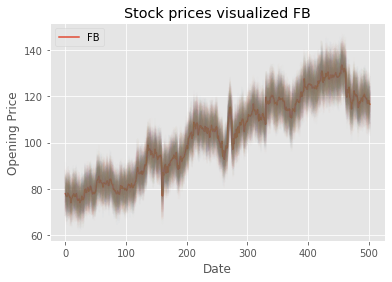

In [ ]:
for ticker, dic in stocks.items():
    # Convert the pandas dataframe to a numpy array
    X = np.array(stocks[ticker]['X'])
    y = np.array(stocks[ticker]['y'])
    fig, ax = plt.subplots()
    ax.plot(range(len(y)),y, label=ticker)
    stocks[ticker]['storage'] = stocks[ticker]['model'].predict(X)
    for line in stocks[ticker]['storage']:
        ax.plot(range(len(line)),line, alpha=0.01)
    plt.legend()
    plt.ylabel("Opening Price")
    plt.xlabel("Date")
    plt.title(f"Stock prices visualized {ticker}")
    plt.show()

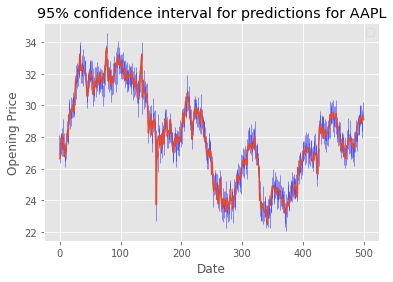

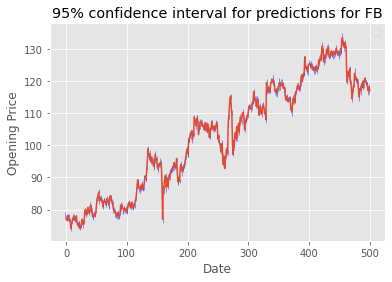

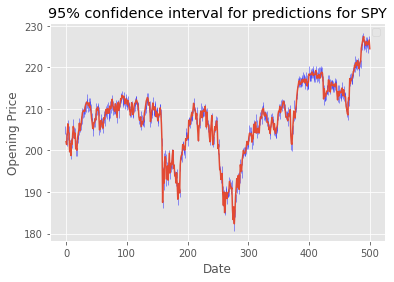

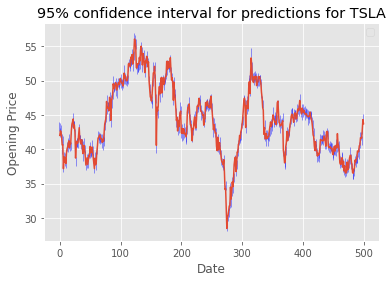

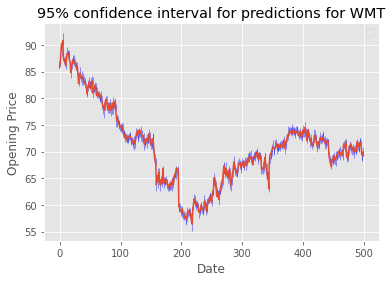

In [ ]:
# Plotting the 95% CI for every stock
for ticker, dic in stocks.items():
    y, stored = dic['y'], np.array(dic['storage'],dtype=np.float64)

    import scipy.stats as st
    
    fig, ax = plt.subplots()
    ax.plot(range(len(y)),y)
    for i in range(len(y)):
      CIs = st.t.interval(alpha=0.95, df=len(stored[:,i])-1, loc=np.mean(stored[:,i]), scale=st.sem(stored[:,i])) 
      ax.fill_between( range(i-1,i), CIs[0], CIs[1], color='b', alpha=.8)
    plt.legend()
    plt.ylabel("Opening Price")
    plt.xlabel("Date")
    plt.title(f"95% confidence interval for predictions for {ticker}")
    plt.show()

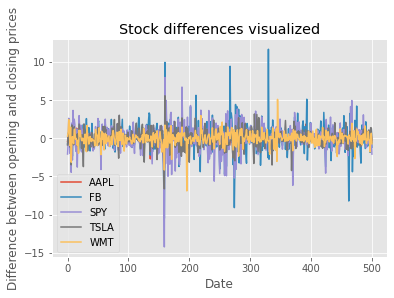

In [ ]:
# Changes between closing price the previous day and opening price next day
for ticker, dic in stocks.items():
    y =  dic['y'] - dic['X'][:,4]
    plt.plot(range(len(y)), y, label=ticker)
plt.legend()
plt.ylabel("Difference between opening and closing prices")
plt.xlabel("Date")
plt.title("Stock differences visualized")
plt.show()

# Convergence test 
We will perform to ensure all chains have econverged and the results are realiable

In [ ]:
for (key, stock) in stocks.items():
  print(key)
  stock['model'].convergence_tests()

AAPL
The number of r_hats above one are 11324
The average effective size is 1.2
FB
The number of r_hats above one are 11324
The average effective size is 1.2
SPY
The number of r_hats above one are 11324
The average effective size is 1.1999999999999997
TSLA
The number of r_hats above one are 11324
The average effective size is 1.2
WMT
The number of r_hats above one are 11324
The average effective size is 1.1999999999999997


In [ ]:
mu, sigma = 100,10
mu1,sigma1 = 200,10
a = 0.5
x = stocks['AAPL']['model'].samples['hidden_to_hidden_weights[1,1,1]']
plt.hist(x, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Parameter hidden layer 1, node 1, connection 1')

Text(0.5, 1.0, 'Parameter hidden layer 1, node 1, connection 1')